ToggleButtons(description='Metric: ', index=3, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'Attention Distribution'), value='Learning Curve')

HBox(children=(Select(description='Participant: ', index=6, options=('All', '#1', '#2', '#3', '#4', '#5', '#6'), value='#6'),))

<IPython.core.display.Javascript object>


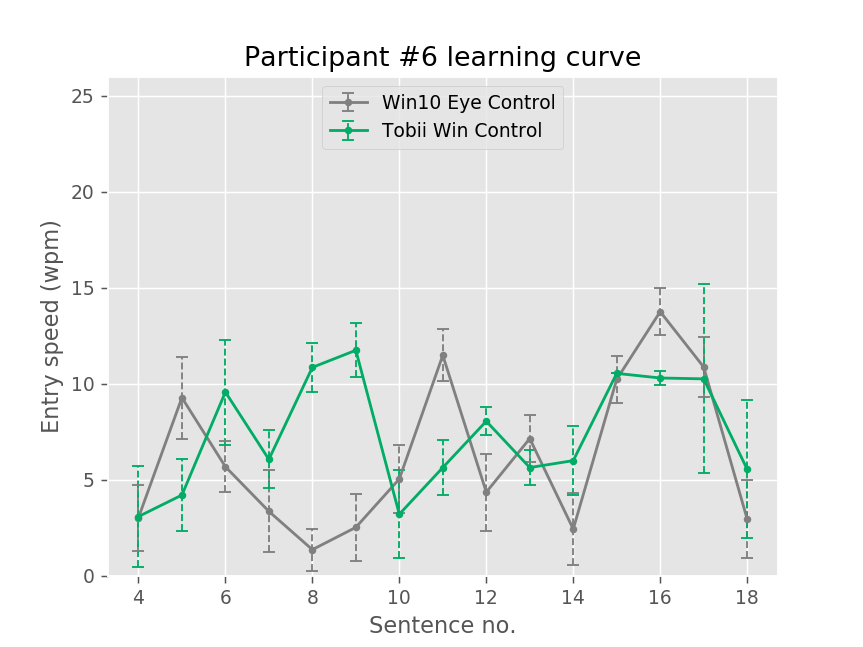

15
16


In [29]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np

class Sentence:
	# class variables here
	def __init__(self, participant, sentenceNo, testing):
		# instance variables here
		self.participant = participant
		self.sentenceNo = sentenceNo
		self.testing = testing		# 0: practice; 1: test
		self.keyboard = 0			# 0: win EyeControl; 1: tobii WinControl; 2: tobii Dwell-free
		self.wpm = 0.0
		self.adjWpm = 0.0
		self.totErrRate = 0.0
		self.uncErrRate = 0.0
		self.corErrRate = 0.0

def readSentences(argFilename, argSentences):
	with open('Raw-Data/Logs/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			argSentences.append(Sentence(int(argFilename[0])-1, int(row[0]), int(row[1])))
			# exclude exceptions that the test participant didn't enter anything and skipped this sentence			
			if row[3] != 0:			
				sentences[-1].wpm = float(row[3])
				sentences[-1].adjWpm = float(row[4])
				sentences[-1].totErrRate = float(row[11])
				sentences[-1].uncErrRate = float(row[9])
				sentences[-1].corErrRate = float(row[10])				
				sentences[-1].keyboard = ord(argFilename[4])-65
		# print(len(sentences))

def clearCache():
	clear_output(wait=True)
	display(contrMetric, widgets.HBox([contrPtcp]))
	# clear data storage
	dataStorage = [perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo]
	for item in dataStorage:
		for index in range(amountPtcp*amountKeyboard):
			del item[index][:]

def onChange_metric(b):
	if b['type']=='change' and b['name']=='value':
		plotsHub()

def onChange_ptcp(change):
	if change['type']=='change' and change['name']=='value':
		plotsHub()

def plotsHub():
	clearCache()
	# extract sentences according to participant selection
	for item in sentences:
		if item.testing == 1:
			if contrPtcp.value != 'All':
				index = (int(contrPtcp.value[1])-1)*amountKeyboard+item.keyboard
				selectedPtcp = [int(contrPtcp.value[1])-1]
			else:
				index = item.participant*amountKeyboard+item.keyboard
				selectedPtcp = [i for i in range(amountPtcp)]
			if item.participant in selectedPtcp:
				perPtcpWpm[index].append(item.wpm)
				perPtcpAdjWpm[index].append(item.adjWpm)
				perPtcpTotErrRate[index].append(item.totErrRate)
				perPtcpUncErrRate[index].append(item.uncErrRate)
				perPtcpCorErrRate[index].append(item.corErrRate)
				perPtcpSentenceNo[index].append(item.sentenceNo)
	filter()
	if 'Speed' == contrMetric.value:
		plotSpeed()
	elif 'Accuracy' == contrMetric.value:
		plotAccuracy()
	elif 'Speed & Accuracy' == contrMetric.value:
		plotSpeedNAccuracy()
	elif 'Learning' in contrMetric.value:
		plotLearningCurve()
	elif 'Speed vs. Accuracy' == contrMetric.value:
		plotSpeedVsAccuracy()	

def filter():
	pass
	# remove outliers that out of 90%

def plotSpeed():
	fig, ax = plt.subplots()
	ax.set(title='Participant '+contrPtcp.value+' typing speed', ylabel='Entry Speed (wpm)')
	plt.ylim(-1,50)
	yWpm = [[] for i in range(amountKeyboard)]
	for index in range(len(perPtcpWpm)):
		for subIndex in range(len(perPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(perPtcpWpm[index][subIndex])
	for i in range(amountKeyboard):
		plt.boxplot(yWpm[i], positions=[plotXPosition[i]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[i]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, labelKeybd)
	fig.savefig('plotSpeed_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotAccuracy():
	fig, ax = plt.subplots()
	ax.set(title='Participant '+contrPtcp.value+' typing accuracy', ylabel='Error Rate')
	plt.ylim(-0.1,1.1)
	yErrRate = [[] for i in range(amountKeyboard)]
	for index in range(len(perPtcpWpm)):
		for subIndex in range(len(perPtcpTotErrRate[index])):
			yErrRate[index%amountKeyboard].append(perPtcpTotErrRate[index][subIndex])
	for i in range(amountKeyboard):
		plt.boxplot(yErrRate[i], positions=[plotXPosition[i]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[i]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, labelKeybd)
	fig.savefig('plotAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedNAccuracy():
	fig, ax = plt.subplots()
	ax.set(title='Participant '+contrPtcp.value+' typing speed with accuracy', ylabel='Entry Speed (wpm)')
	plt.ylim(-1,20)
	yWpm, sdTotErrRate = ([[] for i in range(amountKeyboard)] for j in range(2))
	for index in range(len(perPtcpWpm)):
		for subIndex in range(len(perPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(perPtcpWpm[index][subIndex])
			sdTotErrRate[index%amountKeyboard].append(perPtcpTotErrRate[index][subIndex])
	for i in range(amountKeyboard):
		eb = plt.errorbar(i+1,np.mean(yWpm[i]),np.mean(sdTotErrRate[i])*np.mean(yWpm[i]),
						fmt='o',color=color[i],elinewidth=1,capsize=3)
		eb[-1][0].set_linestyle('--')
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, axisKeybd)
	fig.savefig('plotSpeedNAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotLearningCurve():
	fig, ax = plt.subplots()
	if contrPtcp.value != 'All':
		for index in range(len(perPtcpWpm)):
			if len(perPtcpWpm[index]):
				sdError = [a*b for a,b in zip(perPtcpWpm[index], perPtcpTotErrRate[index])]
				print(index)
				eb = plt.errorbar(perPtcpSentenceNo[index],perPtcpWpm[index],sdError,
					fmt='.-',color=color[index],elinewidth=1,capsize=3,label=labelKeybd[index])
				eb[-1][0].set_linestyle('--')
	else:
		yPerSentenceWpm, yPerSentenceTotErrRate = ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)] for k in range(2))
		tmpPerSentenceNo = [j for j in range(4,19)]
		for index in range(len(perPtcpWpm)):
			for indexSub in range(len(perPtcpWpm[index])):
				i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
				yPerSentenceWpm[index%amountKeyboard][index//amountKeyboard][i] = perPtcpWpm[index][indexSub]
				yPerSentenceTotErrRate[index%amountKeyboard][index//amountKeyboard][i] = perPtcpTotErrRate[index][indexSub]
		yWpm, sdTotErrRate = ([([0]*15)for p in range(amountKeyboard)] for q in range(2))
		for i in range(amountKeyboard):
			for j in range(15):
				bufferWpm, bufferErrRate = ([] for q in range(2))
				for k in range(amountPtcp):
					if yPerSentenceWpm[i][k][j] != 0:
						bufferWpm.append(yPerSentenceWpm[i][k][j])
						bufferErrRate.append(yPerSentenceTotErrRate[i][k][j])
				if len(bufferWpm) <= amountPtcp: # threshold = 0.3
					yWpm[i][j] = np.mean(bufferWpm)
					sdTotErrRate[i][j] = np.mean(bufferErrRate)
				else:
					yWpm[i][j] = 0
					sdTotErrRate[i][j] = 0
			eb = plt.errorbar([q for q in range(4,19)], yWpm[i], sdTotErrRate[i],
							fmt='.-',color=color[i],elinewidth=1,capsize=3,label=labelKeybd[i])
			eb[-1][0].set_linestyle('--')
	ax.legend(loc='upper center')
	ax.set(title='Participant '+contrPtcp.value+' learning curve', xlabel='Sentence no.', ylabel='Entry speed (wpm)')
	plt.ylim(0, 26)
	fig.savefig('plotLearningCurve_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedVsAccuracy():
	pass	

def plotAttention(): 
	pass

if __name__=="__main__":
	amountPtcp=6
	amountKeyboard=3
	sentences=[]
	perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo = ([[] for j in range(amountPtcp*amountKeyboard)] for i in range(6))
	plotXPosition = [1,2,3]
	labelKeybd = ['Win10 Eye Control', 'Tobii Win Control', 'Tobii Dwell-free'] * 6
	axisKeybd = ['Win10\nEye Control', 'Tobii\nWin Control', 'Tobii\nDwell-free'] * 6
	color = ['gray', '#01ac66','green'] * 6 

	filenames = ['1_kbB_logs', '2_kbA_logs', '2_kbB_logs', 
				'3_kbA_logs', '3_kbB_logs', 
				'4_kbA_logs', '4_kbB_logs', 
				'5_kbA_logs', '5_kbB_logs', 
				'6_kbA_logs', '6_kbB_logs']
	for item in filenames:
		readSentences(item, sentences)

	contrMetric = widgets.ToggleButtons(
		options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'Attention Distribution'],
		description='Metric: ',
		value='Learning Curve',
		disabled=False
		)
	contrPtcp = widgets.Select(
		options=['All', '#1', '#2', '#3', '#4', '#5', '#6'],
		description='Participant: ',
		value='All',
		disabled=False
		)
	display(contrMetric, widgets.HBox([contrPtcp]))
	contrMetric.observe(onChange_metric)
	contrPtcp.observe(onChange_ptcp)

In [41]:
[[] for m in range(amountKeyboard)]

[[], [], []]